Some preprocessing

In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
import importlib
import models.loss
importlib.reload(models.loss)

<module 'models.loss' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/loss.py'>

In [5]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from utils.standardize import std_mat, std_vec

In [6]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

# produce base metrics

In [7]:
from models.loss import reg_R_fn, lin_R_fn

In [8]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc"))
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
psd_all = 10 * np.log10(psd_all)
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

# real data
all_data = psd_all.transpose(3, 2, 0, 1)
all_data_std = (all_data - all_data.mean(axis=-1, keepdims=True))/all_data.std(axis=-1, keepdims=True);

In [16]:
all_data_std.shape

(36, 360, 68, 39)

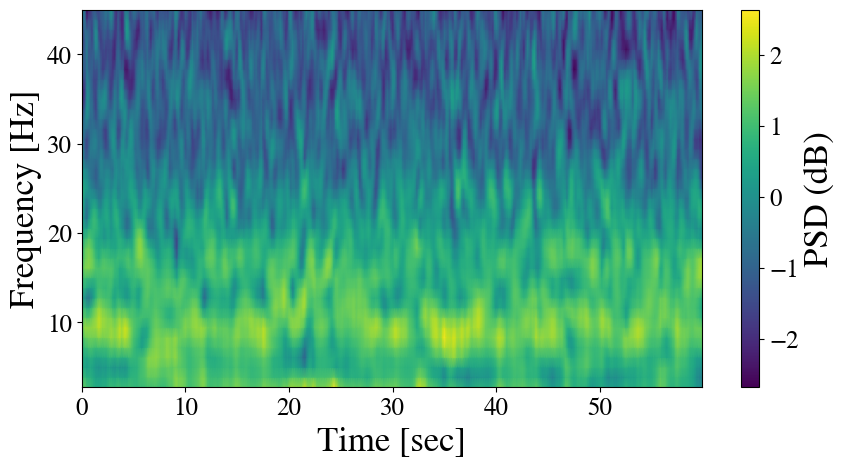

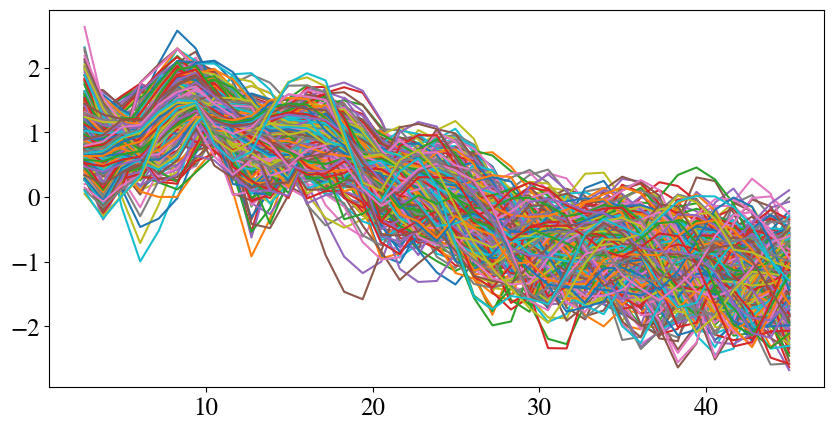

In [18]:
std_mat = all_data_std[1, :, 0] # num_sps x num_ts x num_rois x num_freqs

plt.pcolormesh(time_points, freqs, std_mat.T, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='PSD (dB)')
plt.show()
plt.close()

for t_ix in range(std_mat.shape[0]):
    plt.plot(freqs, std_mat[t_ix, :])

In [9]:
# the simulated data
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_sgm_data_ind_large", including=["PSDs_test"]);

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_large/PSDs_test.pkl


In [10]:
base_PSDs_dB = 20*np.log10(simu_sgm_data.PSDs_test[:1000]);
base_PSDs_dB_std = (base_PSDs_dB - base_PSDs_dB.mean(axis=-1, keepdims=True))/base_PSDs_dB.std(axis=-1, keepdims=True);

In [11]:
# path to save
target_path = DATA_ROOT/(fils[0].stem + "_base_1000")
if not target_path.exists():
    target_path.mkdir()

In [12]:
def _all2stat_fn(corrs):
    """output useful stats for the base corrs
    """
    res = edict()
    if corrs.ndim == 1:
        res.mean = np.mean(corrs)
        res.median = np.median(corrs)
        res.std = np.std(corrs)
    elif corrs.ndim == 2:
        assert corrs.shape[-1] == 68
        res.mean = np.mean(corrs, axis=0)
        res.median = np.median(corrs, axis=0)
        res.std = np.std(corrs, axis=0)
    return res

## Reg R

In [13]:
for sub_ix in trange(all_data_std.shape[0]):
    cur_sub_corrs = []
    cur_sub_corrs_roiwise = []
    for time_ix in range(all_data_std.shape[1]):
        cur_data = all_data_std[sub_ix, time_ix];
        cur_data_rep = np.repeat(cur_data[np.newaxis], len(base_PSDs_dB_std), axis=0)
        base_corrs_roiwise  = reg_R_fn(base_PSDs_dB_std, cur_data_rep)
        base_corrs = reg_R_fn(base_PSDs_dB_std.mean(axis=1), 
                              cur_data_rep.mean(axis=1))
        cur_sub_corrs_roiwise.append(_all2stat_fn(base_corrs_roiwise))
        cur_sub_corrs.append(_all2stat_fn(base_corrs))
        
    save_pkl(target_path/f"regR_{sub_ix}.pkl", cur_sub_corrs)
    save_pkl(target_path/f"regR_roiwise_{sub_ix}.pkl", cur_sub_corrs_roiwise)

  3%|███▊                                                                                                                                       | 1/36 [00:18<10:31, 18.03s/it]

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_0.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_0.pkl exists! Use is_force=True to save it anyway


  6%|███████▋                                                                                                                                   | 2/36 [00:36<10:15, 18.11s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_1.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_1.pkl


  8%|███████████▌                                                                                                                               | 3/36 [00:54<09:57, 18.10s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_2.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_2.pkl


 11%|███████████████▍                                                                                                                           | 4/36 [01:12<09:36, 18.01s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_3.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_3.pkl


 14%|███████████████████▎                                                                                                                       | 5/36 [01:30<09:17, 17.97s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_4.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_4.pkl


 17%|███████████████████████▏                                                                                                                   | 6/36 [01:47<08:58, 17.95s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_5.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_5.pkl


 19%|███████████████████████████                                                                                                                | 7/36 [02:05<08:40, 17.93s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_6.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_6.pkl


 22%|██████████████████████████████▉                                                                                                            | 8/36 [02:23<08:21, 17.92s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_7.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_7.pkl


 25%|██████████████████████████████████▊                                                                                                        | 9/36 [02:41<08:03, 17.92s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_8.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_8.pkl


 28%|██████████████████████████████████████▎                                                                                                   | 10/36 [02:59<07:45, 17.91s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_9.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_9.pkl


 31%|██████████████████████████████████████████▏                                                                                               | 11/36 [03:17<07:27, 17.89s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_10.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_10.pkl


 33%|██████████████████████████████████████████████                                                                                            | 12/36 [03:35<07:09, 17.88s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_11.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_11.pkl


 36%|█████████████████████████████████████████████████▊                                                                                        | 13/36 [03:53<06:51, 17.88s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_12.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_12.pkl


 39%|█████████████████████████████████████████████████████▋                                                                                    | 14/36 [04:11<06:33, 17.89s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_13.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_13.pkl


 42%|█████████████████████████████████████████████████████████▌                                                                                | 15/36 [04:28<06:15, 17.89s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_14.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_14.pkl


 44%|█████████████████████████████████████████████████████████████▎                                                                            | 16/36 [04:46<05:58, 17.91s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_15.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_15.pkl


 47%|█████████████████████████████████████████████████████████████████▏                                                                        | 17/36 [05:04<05:39, 17.87s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_16.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_16.pkl


 50%|█████████████████████████████████████████████████████████████████████                                                                     | 18/36 [05:22<05:21, 17.85s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_17.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_17.pkl


 53%|████████████████████████████████████████████████████████████████████████▊                                                                 | 19/36 [05:40<05:03, 17.84s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_18.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_18.pkl


 56%|████████████████████████████████████████████████████████████████████████████▋                                                             | 20/36 [05:58<04:45, 17.82s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_19.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_19.pkl


 58%|████████████████████████████████████████████████████████████████████████████████▌                                                         | 21/36 [06:15<04:27, 17.80s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_20.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_20.pkl


 61%|████████████████████████████████████████████████████████████████████████████████████▎                                                     | 22/36 [06:33<04:09, 17.80s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_21.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_21.pkl


 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 23/36 [06:51<03:53, 17.97s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_22.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_22.pkl


 67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 24/36 [07:10<03:37, 18.09s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_23.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_23.pkl


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 25/36 [07:28<03:20, 18.19s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_24.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_24.pkl


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 26/36 [07:47<03:02, 18.25s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_25.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_25.pkl


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 27/36 [08:05<02:44, 18.29s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_26.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_26.pkl


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 28/36 [08:23<02:26, 18.32s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_27.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_27.pkl


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 29/36 [08:42<02:08, 18.33s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_28.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_28.pkl


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 30/36 [09:00<01:50, 18.36s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_29.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_29.pkl


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 31/36 [09:19<01:31, 18.37s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_30.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_30.pkl


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 32/36 [09:37<01:13, 18.38s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_31.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_31.pkl


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 33/36 [09:55<00:55, 18.40s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_32.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_32.pkl


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 34/36 [10:14<00:36, 18.36s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_33.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_33.pkl


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 35/36 [10:32<00:18, 18.33s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_34.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_34.pkl


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [10:50<00:00, 18.08s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_35.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/individual_wavelet_reordered_smooth_raw_s100tp_base_1000/regR_roiwise_35.pkl


## linR

In [ ]:
for sub_ix in trange(all_data_std.shape[0]):
    cur_sub_corrs = []
    cur_sub_corrs_roiwise = []
    for time_ix in range(all_data_std.shape[1]):
        cur_data = all_data_std[sub_ix, time_ix];
        cur_data_rep = np.repeat(cur_data[np.newaxis], len(base_PSDs_dB_std), axis=0)
        base_corrs_roiwise  = lin_R_fn(base_PSDs_dB_std, cur_data_rep)
        base_corrs = lin_R_fn(base_PSDs_dB_std.mean(axis=1), 
                              cur_data_rep.mean(axis=1))
        cur_sub_corrs_roiwise.append(_all2stat_fn(base_corrs_roiwise))
        cur_sub_corrs.append(_all2stat_fn(base_corrs))
        
    save_pkl(target_path/f"linR_{sub_ix}.pkl", cur_sub_corrs)
    save_pkl(target_path/f"linR_roiwise_{sub_ix}.pkl", cur_sub_corrs_roiwise)

  0%|                                                                                                                                                   | 0/36 [00:00<?, ?it/s]